In [8]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as signal
from scipy.fft import fft, fftfreq

In [2]:
# Import data
source_folder = str("ECGdata_child\\")
filenames = ["abdomen1.txt", "abdomen2.txt", "abdomen3.txt", "thorax1.txt", "thorax2.txt"]
dfs = ["abd1", "abd2", "abd3", "thr1", "thr2"]
data = pd.DataFrame()

for i in range(0, len(filenames)):
    data[dfs[i]] = pd.read_csv(source_folder + filenames[i], sep=" ", names=[dfs[i]])

data = data.reset_index(drop = True)

In [3]:
def highpass(data, cutoff, order):
        """
        Apply a high-pass Butterworth filter to the given data.

        Parameters:
        - data_key (str): Key to access the data frame.
        - cutoff (float): Cutoff frequency for the high-pass filter.
        - order (int): Order of the Butterworth filter.

        Returns:
        - numpy.ndarray: High-pass filtered data.
        """
        t = 20  # seconds
        freqHz = int(len(data) / t)

        nyq = 0.5 * freqHz
        normal_cutoff = cutoff / nyq
        b, a = signal.butter(order, normal_cutoff, btype="high", analog=False)
        y = signal.filtfilt(b, a, data)
        return y

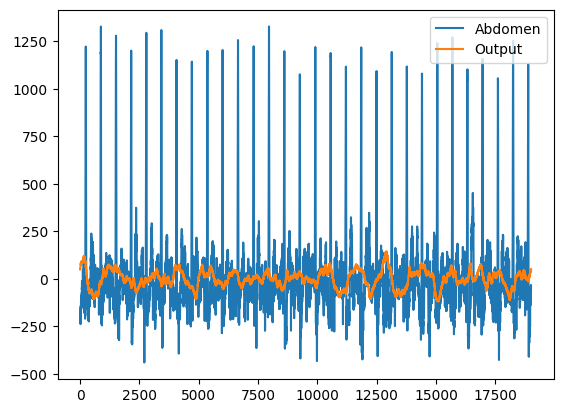

In [15]:
# High-pass filter
thorax_data = highpass(data['thr2'], 2, 1)

# Create training data from sliding window
window_size = 1000
training_data = np.lib.stride_tricks.sliding_window_view(thorax_data, window_size).T

# Create target data
target_value = 0.1
target_data = np.full((np.shape(training_data)[1],1), target_value)

# Linear regression
alpha = 0.01 # Parameter for ridge regression
cov = np.cov(training_data) + alpha * alpha
inv_cov = np.linalg.inv(cov)
weights = np.matmul(inv_cov, training_data)
weights = np.matmul(weights, target_data).T[0]

# Determine output
abdomen_data = highpass(data['abd3'], 2, 1)
output = []
for idx in range(window_size, len(abdomen_data)+1):
    vector = abdomen_data[idx-window_size:idx]
    output.append(np.dot(vector, weights))

# Plot figure
plt.plot(abdomen_data[window_size:], label="Abdomen")
plt.plot(output, label="Output")
plt.legend()
plt.show()